# Laboratorio 6: Clasificación de malware con DL
#### Universidad del Valle de Guatemala
#### CC3094 - Security Data Science - Sección 10
#### Oliver De León - 19270
#### Julio Herrera - 19402
#### Diego Arredondo - 19422

# Parte 1: Procesamiento de datos

In [20]:
import pandas as pd
import os
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib

In [21]:
def load(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [256, 256])
    img = tf.cast(img, tf.float32)
    img = img / 127.5 - 1
    return img

def load_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (256, 256))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 127.5 - 1
    return img

Contando la cantidad total de imagenes de distintos tipos

In [22]:
image_count = len(list(pathlib.Path('./malimg_paper_dataset_imgs').glob('*/*.png')))
print(image_count)

9339


Algunos ejemplos de imagenes de malware tipo Adialer.C

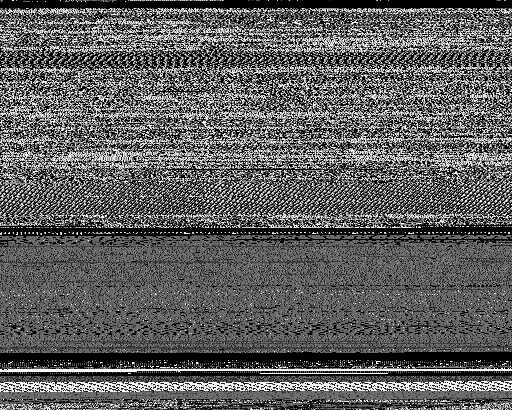

In [23]:
adialer_c = list(pathlib.Path('./malimg_paper_dataset_imgs/Adialer.C').glob('*.png'))
PIL.Image.open(str(adialer_c[0]))

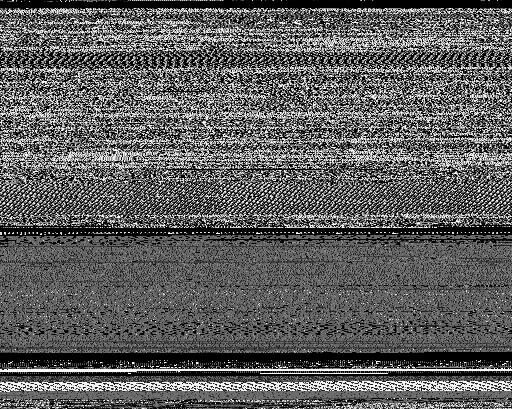

In [24]:
PIL.Image.open(str(adialer_c[1]))

Algunos ejemplos de imagenes de malware tipo Agent.FYI

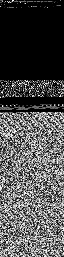

In [25]:
agent_fy = list(pathlib.Path('./malimg_paper_dataset_imgs/Agent.FYI').glob('*.png'))
PIL.Image.open(str(agent_fy[0]))

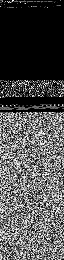

In [26]:
PIL.Image.open(str(agent_fy[1]))

Algunos ejemplos de imagenes de malware tipo Allaple.A

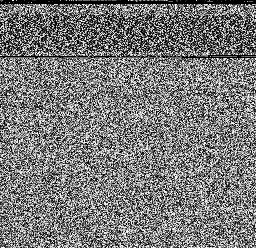

In [27]:
allaple_a = list(pathlib.Path('./malimg_paper_dataset_imgs/Allaple.A').glob('*.png'))
PIL.Image.open(str(allaple_a[0]))

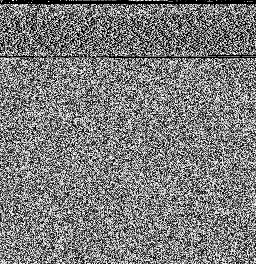

In [28]:
PIL.Image.open(str(allaple_a[1]))

### Cargando datos a un dataset de TensorFlow

In [29]:
# parametros para el cargador
batch_size = 32
img_height = 256
img_width = 256

De una vez se separa el dataset en 70% para entrenamiento y 30% para validación

In [30]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    './malimg_paper_dataset_imgs',
    validation_split=0.3,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 9339 files belonging to 25 classes.
Using 6538 files for training.


In [31]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    './malimg_paper_dataset_imgs',
    validation_split=0.3,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 9339 files belonging to 25 classes.
Using 2801 files for validation.


El nombre de la clase está en el atributo class_name

In [32]:
class_names = train_ds.class_names
print(class_names)

['Adialer.C', 'Agent.FYI', 'Allaple.A', 'Allaple.L', 'Alueron.gen!J', 'Autorun.K', 'C2LOP.P', 'C2LOP.gen!g', 'Dialplatform.B', 'Dontovo.A', 'Fakerean', 'Instantaccess', 'Lolyda.AA1', 'Lolyda.AA2', 'Lolyda.AA3', 'Lolyda.AT', 'Malex.gen!J', 'Obfuscator.AD', 'Rbot!gen', 'Skintrim.N', 'Swizzor.gen!E', 'Swizzor.gen!I', 'VB.AT', 'Wintrim.BX', 'Yuner.A']


### Visualizacion de los datos

Ahora ya podemos ver las imagenes desde el dataset, a continuación se muestran 9 imagenes del dataset de entrenamiento y su tipo de malware

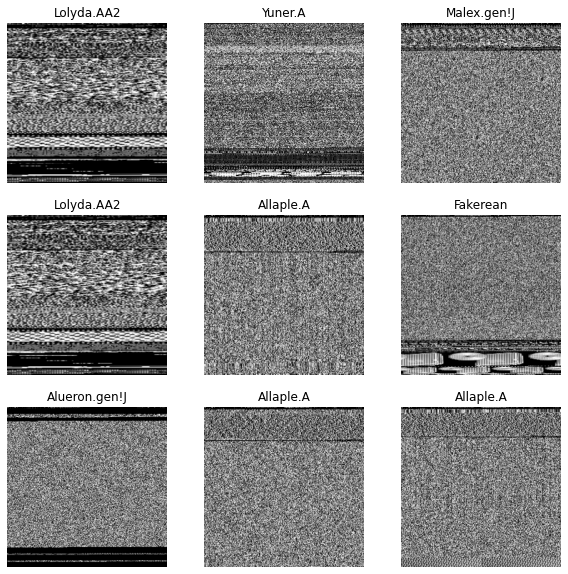

In [33]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Configurando el conjunto de datos para el rendimiento

In [34]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Creación del modelo

In [35]:
num_classes = len(class_names)

model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)), # normaliza los valores de los pixeles
    layers.Conv2D(16, 3, padding='same', activation='relu'), # capa convolucional
    layers.MaxPooling2D(), # capa de pooling
    layers.Conv2D(32, 3, padding='same', activation='relu'), # capa convolucional
    layers.MaxPooling2D(), # capa de pooling
    layers.Conv2D(64, 3, padding='same', activation='relu'), # capa convolucional
    layers.MaxPooling2D(), # capa de pooling
    layers.Flatten(), # capa de aplanamiento
    layers.Dense(128, activation='relu'), # capa densa
    layers.Dense(num_classes) # capa densa
])

### Compilando el modelo

In [36]:
model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

### Resumen del modelo antes de entrenar

In [37]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 128, 128, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 64)       

### Entranando el modelo

In [38]:
epochs=10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/10
205/205 [==============================] - 155s 723ms/step - loss: 0.7074 - accuracy: 0.8396 - val_loss: 0.1277 - val_accuracy: 0.9593
Epoch 2/10
205/205 [==============================] - 145s 708ms/step - loss: 0.0953 - accuracy: 0.9712 - val_loss: 0.0903 - val_accuracy: 0.9764
Epoch 3/10
205/205 [==============================] - 144s 704ms/step - loss: 0.0362 - accuracy: 0.9867 - val_loss: 0.0664 - val_accuracy: 0.9807
Epoch 4/10
205/205 [==============================] - 145s 706ms/step - loss: 0.0230 - accuracy: 0.9927 - val_loss: 0.0587 - val_accuracy: 0.9843
Epoch 5/10
205/205 [==============================] - 145s 705ms/step - loss: 0.0173 - accuracy: 0.9950 - val_loss: 0.0648 - val_accuracy: 0.9843
Epoch 6/10
205/205 [==============================] - 144s 704ms/step - loss: 0.0148 - accuracy: 0.9948 - val_loss: 0.0622 - val_accuracy: 0.9814
Epoch 7/10
205/205 [==============================] - 145s 707ms/step - loss: 0.0086 - accuracy: 0.9971 - val_loss: 0.0767 -

### Visualizando los resultados del entrenamiento

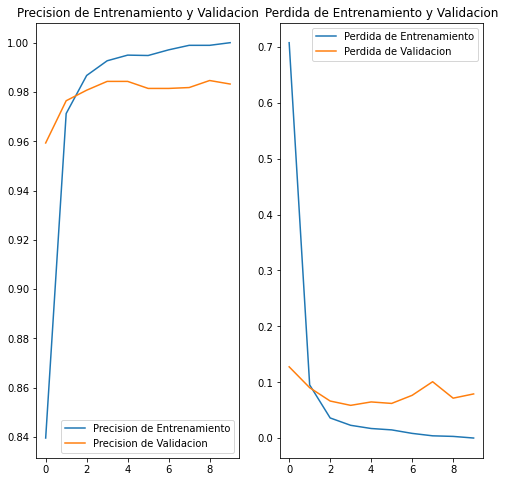

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

# grafica de la precision
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Precision de Entrenamiento')
plt.plot(epochs_range, val_acc, label='Precision de Validacion')
plt.legend(loc='lower right')
plt.title('Precision de Entrenamiento y Validacion')

# grafica de la perdida
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Perdida de Entrenamiento')
plt.plot(epochs_range, val_loss, label='Perdida de Validacion')
plt.legend(loc='upper right')
plt.title('Perdida de Entrenamiento y Validacion')
plt.show()

### Prediciendo con nuevas imagenes

Del paper Visualized Malware Multi-Classification Framework Using Fine-Tuned CNN-Based Transfer Learning Models obtenido de: https://www.researchgate.net/publication/353223836_Visualized_Malware_Multi-Classification_Framework_Using_Fine-Tuned_CNN-Based_Transfer_Learning_Models

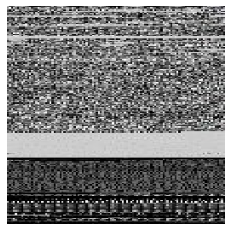

1/1 [==============================] - 0s 134ms/step
Esta imagen es de Rbot!gen con un 72.97 porciento de confianza.


In [40]:
# load individual image from path
test_img = keras.preprocessing.image.load_img(
    './validation/img101.jpg', target_size=(img_height, img_width)
)

# convert image to array
test_img_array = keras.preprocessing.image.img_to_array(test_img)

# plot image
plt.imshow(test_img_array.astype("uint8"))
plt.axis("off")
plt.show()

# add extra dimension to image
test_img_array = tf.expand_dims(test_img_array, 0)

# predict image
predictions = model.predict(test_img_array)
score = tf.nn.softmax(predictions[0])

print(
    "Esta imagen es de {} con un {:.2f} porciento de confianza."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

### Discusión

Para este laboratorio se usó un dataset com más de 8 millones de parametros entrenables, seguidamente se dividió el dataset en un 70% entrenamiento y 30% de pruebas. El modelo fue entrenado con numero de 10 épocas, este valor se considero el mejor para el laboratorio.

Al revisar los resultados del modelo entrenado, se obtuvo que dicho modelo al hacer pruebas, el pocentaje de confianza ronda entre el 70 y 75% de presición. Este valor indica que el modelo puede predecir de una manera eficiente, pero no tan confiable porque el valor no es tan alto.